In [21]:
!pip install trl
!pip install bitsandbytes

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments
)
from peft import LoraConfig
from trl import SFTTrainer

DATA_SOURCE = "databricks/databricks-dolly-15k"
MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"  # Kullandığınız model
OUTPUT_DIR = "./trained_models"

# Overfitting Önleyici Ayarlar
CONF_EPOCHS = 1          # 1 Epoch (Ezberlemeyi önler)
CONF_LR = 2e-5           # Düşük Learning Rate
CONF_BATCH = 4           # GPU belleğine göre 2 veya 4 yapın
CONF_GRAD_ACC = 4

# Görseldeki instruction, context ve response sütunlarını tek bir metne çevirir.
def formatting_prompts_func(example):
    output_texts = []
    # Batch halindeki veriyi döngüye alıyoruz
    for i in range(len(example['instruction'])):
        instruction = example['instruction'][i]
        context = example['context'][i]
        response = example['response'][i]

        # Eğer context sütunu doluysa onu da ekle, boşsa sadece instruction kullan
        if context and len(str(context)) > 0:
            text = f"### Instruction:\n{instruction}\n\n### Context:\n{context}\n\n### Response:\n{response}"
        else:
            text = f"### Instruction:\n{instruction}\n\n### Response:\n{response}"

        output_texts.append(text)
    return output_texts

# 1. BÖLÜM: VERİ HAZIRLAMA VE BÖLÜMLEME

def prepare_data():
    print(">>> Veri yükleniyor...")

    # Veri setini yükle
    # Eğer local jsonl dosyanız varsa: load_dataset("json", data_files="dosya.jsonl", split="train")
    dataset = load_dataset(DATA_SOURCE, split="train")

    # 2. Test Setini Ayır (Yönerge: En az 500 soru)
    # 15k veri olduğu için 500 tanesini güvenle ayırabiliriz.
    split_dataset = dataset.train_test_split(test_size=500, seed=42)
    test_data = split_dataset["test"]
    train_data_full = split_dataset["train"]

    os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
    test_data.to_json(f"{OUTPUT_DIR}/data/test_set_final.jsonl")
    print(f"--- Test seti ayrıldı: {len(test_data)} örnek")

    # --- SENARYO 1: RASTGELE KESİŞMEYEN PARÇALAR (Random Splits) ---
    print("\n>>> Senaryo 1 verileri hazırlanıyor...")
    shuffled_data = train_data_full.shuffle(seed=42)

    # Ödev için 3 farklı rastgele model eğitelim.
    # Veriyi 3 eşit parçaya bölüyoruz.
    NUM_SPLITS = 3
    total_len = len(shuffled_data)
    chunk_size = total_len // NUM_SPLITS

    random_files = []
    for i in range(NUM_SPLITS):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < NUM_SPLITS - 1 else total_len

        subset = shuffled_data.select(range(start, end))
        # Dosya ismi oluştur
        fname = f"{OUTPUT_DIR}/data/train_random_{i+1}.jsonl"
        subset.to_json(fname)
        random_files.append(fname)
        print(f"    - Random Split {i+1} dosyası yazıldı: {len(subset)} örnek")

    # --- SENARYO 2: KONU BAZLI PARÇALAR (Topic Splits) ---
    print("\n>>> Senaryo 2 verileri hazırlanıyor (Category sütununa göre)...")
    # Görselde sütun adı 'category' olarak gözüküyor.
    TOPIC_COLUMN = "category"

    # Benzersiz kategorileri bul
    unique_topics = set(train_data_full[TOPIC_COLUMN])

    topic_files = []
    for topic in unique_topics:
        # Sadece o konuya ait verileri filtrele
        subset = train_data_full.filter(lambda x: x[TOPIC_COLUMN] == topic)

        # Çok küçük kategorileri elemek isteyebilirsiniz (opsiyonel)
        if len(subset) > 100:
            safe_topic_name = str(topic).replace(" ", "_").lower()
            fname = f"{OUTPUT_DIR}/data/train_topic_{safe_topic_name}.jsonl"
            subset.to_json(fname)
            topic_files.append((safe_topic_name, fname))
            print(f"    - Topic Split ({topic}) dosyası yazıldı: {len(subset)} örnek")

    return random_files, topic_files

# 2. BÖLÜM: EĞİTİM FONKSİYONU
def train_model(data_file, output_name):
    print(f"\n>>> Eğitim Başlıyor: {output_name}")

    # JSONL dosyasını yükle
    dataset = load_dataset("json", data_files=data_file, split="train")

    # Quantization (4-bit) Ayarı - Hafıza tasarrufu için
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    # Modeli Yükle
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    # LoRA (Parameter Efficient Fine-Tuning) Ayarı
    peft_config = LoraConfig(
        r=64,
        lora_alpha=16,
        lora_dropout=0.1,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "v_proj"]
    )

    training_args = TrainingArguments(
        output_dir=f"{OUTPUT_DIR}/{output_name}",
        num_train_epochs=CONF_EPOCHS,        # ÖNEMLİ: 1 Epoch
        per_device_train_batch_size=CONF_BATCH,
        gradient_accumulation_steps=CONF_GRAD_ACC,
        learning_rate=CONF_LR,               # ÖNEMLİ: Düşük LR
        weight_decay=0.001,
        logging_steps=10,
        save_strategy="no",                  # Ara kayıt almayalım, yer kaplamasın
        optim="paged_adamw_32bit",
        report_to="none"
    )

    # Trainer Başlatılıyor
    trainer = SFTTrainer(
        model=model,
        train_dataset=dataset,
        peft_config=peft_config,
        formatting_func=formatting_prompts_func, # ÖNEMLİ: Veriyi formata sokan fonksiyon
        max_seq_length=512,
        tokenizer=tokenizer,
        args=training_args,
    )

    trainer.train()

    # Modeli (Adapter) kaydet
    trainer.model.save_pretrained(f"{OUTPUT_DIR}/{output_name}/final_adapter")
    print(f">>> {output_name} tamamlandı.")

    # Bellek temizliği
    del model, trainer
    torch.cuda.empty_cache()

# 3. BÖLÜM: ANA ÇALIŞTIRMA BLOKU
if __name__ == "__main__":

    # 1. Verileri hazırla (Splits)
    random_splits_files, topic_splits_files = prepare_data()

    # 2. Senaryo 1: Rastgele Modelleri Eğit
    print("\n*** SENARYO 1 BAŞLIYOR (Random Splits) ***")
    for i, file_path in enumerate(random_splits_files):
        model_id = f"model_random_{i+1}"
        train_model(file_path, model_id)

    # 3. Senaryo 2: Konu Bazlı Modelleri Eğit
    print("\n*** SENARYO 2 BAŞLIYOR (Topic Splits) ***")
    for topic_name, file_path in topic_splits_files:
        model_id = f"model_topic_{topic_name}"
        train_model(file_path, model_id)

    print("\n!!! TÜM SÜREÇ TAMAMLANDI. MODELLER 'trained_models' KLASÖRÜNDE. !!!")

>>> Veri yükleniyor...


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

--- Test seti ayrıldı: 500 örnek

>>> Senaryo 1 verileri hazırlanıyor...


Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

    - Random Split 1 dosyası yazıldı: 4837 örnek


Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

    - Random Split 2 dosyası yazıldı: 4837 örnek


Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

    - Random Split 3 dosyası yazıldı: 4837 örnek

>>> Senaryo 2 verileri hazırlanıyor (Category sütununa göre)...


Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

    - Topic Split (classification) dosyası yazıldı: 2067 örnek


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

    - Topic Split (closed_qa) dosyası yazıldı: 1710 örnek


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

    - Topic Split (summarization) dosyası yazıldı: 1141 örnek


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

    - Topic Split (creative_writing) dosyası yazıldı: 678 örnek


Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

    - Topic Split (open_qa) dosyası yazıldı: 3638 örnek


Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

    - Topic Split (general_qa) dosyası yazıldı: 2116 örnek


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

    - Topic Split (brainstorming) dosyası yazıldı: 1696 örnek


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

    - Topic Split (information_extraction) dosyası yazıldı: 1465 örnek

*** SENARYO 1 BAŞLIYOR (Random Splits) ***

>>> Eğitim Başlıyor: model_random_1


Generating train split: 0 examples [00:00, ? examples/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Map:   0%|          | 0/4837 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.321400
20,2.319300
30,2.325400
40,2.209900
50,2.106900
60,2.171100
70,2.159500
80,2.072600
90,2.059500
100,2.147800


>>> model_random_1 tamamlandı.

>>> Eğitim Başlıyor: model_random_2


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/4837 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.344800
20,2.332300
30,2.236700
40,2.275600
50,2.245900
60,2.128600
70,2.203500
80,2.159400
90,2.088300
100,2.135300


>>> model_random_2 tamamlandı.

>>> Eğitim Başlıyor: model_random_3


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/4837 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.319900
20,2.347700
30,2.255600
40,2.318500
50,2.196800
60,2.252000
70,2.140300
80,2.131700
90,2.228500
100,1.970800


>>> model_random_3 tamamlandı.

*** SENARYO 2 BAŞLIYOR (Topic Splits) ***

>>> Eğitim Başlıyor: model_topic_classification


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/2067 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.359800
20,2.201300
30,2.315600
40,2.217300
50,2.173100
60,2.061100
70,2.112900
80,1.981400
90,2.040300
100,1.932600


>>> model_topic_classification tamamlandı.

>>> Eğitim Başlıyor: model_topic_closed_qa


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1710 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.222400
20,2.202500
30,2.106000
40,2.156300
50,2.165500
60,2.131000
70,2.039100
80,2.069400
90,2.146500
100,2.025100


>>> model_topic_closed_qa tamamlandı.

>>> Eğitim Başlıyor: model_topic_summarization


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1141 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.077400
20,2.098200
30,2.096400
40,1.996500
50,2.034700
60,2.004400
70,2.124500


>>> model_topic_summarization tamamlandı.

>>> Eğitim Başlıyor: model_topic_creative_writing


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/678 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.676600
20,2.595800
30,2.616100
40,2.665300


>>> model_topic_creative_writing tamamlandı.

>>> Eğitim Başlıyor: model_topic_open_qa


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/3638 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.590200
20,2.558200
30,2.423000
40,2.399200
50,2.308300
60,2.334900
70,2.329800
80,2.311000
90,2.123900
100,2.222800


>>> model_topic_open_qa tamamlandı.

>>> Eğitim Başlıyor: model_topic_general_qa


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/2116 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.541800
20,2.471800
30,2.469900
40,2.510800
50,2.456800
60,2.390100
70,2.379400
80,2.413000
90,2.361400
100,2.348000


>>> model_topic_general_qa tamamlandı.

>>> Eğitim Başlıyor: model_topic_brainstorming


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1696 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.553300
20,2.509000
30,2.486500
40,2.424500
50,2.335800
60,2.326200
70,2.524600
80,2.339900
90,2.315600
100,2.316500


>>> model_topic_brainstorming tamamlandı.

>>> Eğitim Başlıyor: model_topic_information_extraction


Generating train split: 0 examples [00:00, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/1465 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/trl/trainer/sft_trainer.py:323: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  super().__init__(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss
10,2.072000
20,2.053600
30,2.083900
40,2.085800
50,2.032400
60,2.069000
70,2.024700
80,2.050600
90,2.100200


>>> model_topic_information_extraction tamamlandı.

!!! TÜM SÜREÇ TAMAMLANDI. MODELLER 'trained_models' KLASÖRÜNDE. !!!


In [3]:
# Unsloth ve TRL gibi gerekli kütüphanelerin kurulumu
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-lxadzh9o/unsloth_e97c6877c621402db31dc92f55280224
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-lxadzh9o/unsloth_e97c6877c621402db31dc92f55280224
  Resolved https://github.com/unslothai/unsloth.git to commit 8ea5338154859ed25b50366cb1264ed4d933eae3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.7/290.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 144.3 MB/s eta 0:00:00

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: trl
    Found existing installation: trl 0.24.0
    Uninstalling trl-0.24.0:
      Successfully uninstalled trl-0.24.0


In [ ]:
import pandas as pd

# Full train setinden örnekler oku
df_sample = pd.read_json("data/train_full.jsonl", lines=True).sample(5)

print("--- EĞİTİM VERİSİNDEN 5 ÖRNEK ---")
for index, row in df_sample.iterrows():
    print(f"\n[Kategori]: {row['category']}")
    print(f"[Model Girdisi (Text)]:\n{row['text'][:200]}...") # Sadece ilk 200 karakteri göster
    print("-" * 50)

--- EĞİTİM VERİSİNDEN 5 ÖRNEK ---

[Kategori]: brainstorming
[Model Girdisi (Text)]:
### Instruction:
Make a list of pets you would want if you knew they wouldn’t bite you

### Response:
1. Tiger
2. Lion
3. Alligator 
4. Polar Bear
5. Killer Whale
6. Pit Viper
7. Jaguar
8. Dinosaur 
9...
--------------------------------------------------

[Kategori]: open_qa
[Model Girdisi (Text)]:
### Instruction:
what does it mean to have brunette hair?

### Response:
A person with brunette hair, or a brunette, is a person with brown or black hair color. People typically fall into the category...
--------------------------------------------------

[Kategori]: open_qa
[Model Girdisi (Text)]:
### Instruction:
Who won the masters in golf in 2019?

### Response:
Tiger Woods won his fifth Green Jacket, and fifteenth major, by one stroke ahead of three runners-up. It left him one shy of Jack N...
--------------------------------------------------

[Kategori]: general_qa
[Model Girdisi (Text)]:
### Instruct

In [ ]:
# Unsloth kurulumu
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_03q6o35/unsloth_f307f787516b4084862d59146d262c86
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-_03q6o35/unsloth_f307f787516b4084862d59146d262c86
  Resolved https://github.com/unslothai/unsloth.git to commit 8ea5338154859ed25b50366cb1264ed4d933eae3


In [25]:
import pandas as pd
#NOT: Eğitim kodunda disk alanından tasarruf etmek için save_strategy="no" (Ara kayıt alma) ayarını kullanmıştık. Bu ayar aktif olduğunda ve kodun sonunda trainer.save_state() komutunu açıkça yazmadığımızda, Hugging Face sadece modelin ağırlıklarını
#Hugging Face sadece modelin ağırlıklarını  (adapter_model.safetensors) kaydeder, ancak eğitim istatistiklerini tutan trainer_state.json dosyasını diske yazmaz. Bu sebeple yukarıdaki gerçek sonuçları kullanarak aşağıdaki tabloyu manuel oluşturdum hocam.
data = {
    "Model Adı": [
        # --- SENARYO 1: RASTGELE KESİŞMEYEN KÜMELER ---
        "model_random_1",
        "model_random_2",
        "model_random_3",

        # --- SENARYO 2: KONU BAZLI KÜMELER ---
        "model_topic_open_qa",
        "model_topic_general_qa",
        "model_topic_classification",
        "model_topic_brainstorming",
        "model_topic_closed_qa",
        "model_topic_information_extraction",
        "model_topic_summarization",
        "model_topic_creative_writing"
    ],
    "Senaryo Türü": [
        "Senaryo 1 (Rastgele - Eşit Dağılım)",
        "Senaryo 1 (Rastgele - Eşit Dağılım)",
        "Senaryo 1 (Rastgele - Eşit Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)",
        "Senaryo 2 (Konu Bazlı - Doğal Dağılım)"
    ],
    "Veri Kaynağı": [
        "Random Split 1",
        "Random Split 2",
        "Random Split 3",
        "Category: Open QA",
        "Category: General QA",
        "Category: Classification",
        "Category: Brainstorming",
        "Category: Closed QA",
        "Category: Information Extraction",
        "Category: Summarization",
        "Category: Creative Writing"
    ],
    # Görsellerdeki son log satırındaki Step değeri
    "Tamamlanan Step": [
        300, 300, 300,   # Randomlar eşit
        220,             # Open QA
        130,             # General QA
        130,             # Classification
        100,             # Brainstorming (Log sonu)
        100,             # Closed QA
        90,              # Info Extraction (Log sonu)
        70,              # Summarization
        40               # Creative Writing
    ],
    # Görsellerdeki son log satırındaki Loss değeri
    "Son Loss Değeri": [
        1.991000, 1.934700, 1.997900,  # Randomlar
        2.077800,        # Open QA
        2.324800,        # General QA
        1.936600,        # Classification
        2.316500,        # Brainstorming
        2.025100,        # Closed QA
        2.100200,        # Info Extraction
        2.124500,        # Summarization
        2.665300         # Creative Writing
    ]
}

df_final_real = pd.DataFrame(data)

# Tabloyu ekrana yazdır (Markdown formatında)
print("\n=== NİHAİ EĞİTİM SONUÇ TABLOSU===")
print(df_final_real.to_markdown(index=False))

# Excel çıktısı almak istersen:
# df_final_real.to_excel("final_egitim_sonuclari.xlsx", index=False)


=== NİHAİ EĞİTİM SONUÇ TABLOSU===
| Model Adı                          | Senaryo Türü                           | Veri Kaynağı                     |   Tamamlanan Step |   Son Loss Değeri |
|:-----------------------------------|:---------------------------------------|:---------------------------------|------------------:|------------------:|
| model_random_1                     | Senaryo 1 (Rastgele - Eşit Dağılım)    | Random Split 1                   |               300 |            1.991  |
| model_random_2                     | Senaryo 1 (Rastgele - Eşit Dağılım)    | Random Split 2                   |               300 |            1.9347 |
| model_random_3                     | Senaryo 1 (Rastgele - Eşit Dağılım)    | Random Split 3                   |               300 |            1.9979 |
| model_topic_open_qa                | Senaryo 2 (Konu Bazlı - Doğal Dağılım) | Category: Open QA                |               220 |            2.0778 |
| model_topic_general_qa           

In [27]:
!pip install evaluate rouge_score

import os
import torch
import pandas as pd
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import evaluate
from tqdm import tqdm


BASE_MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
TEST_DATA_PATH = "./trained_models/data/test_set_final.jsonl"
OUTPUT_DIR = "./trained_models"
RESULTS_FILE = "final_test_results.xlsx"

# Hesaplama için Rouge metriğini yükle
rouge = evaluate.load("rouge")

# YARDIMCI FONKSİYONLAR

def generate_response(model, tokenizer, instruction, context=None):
    # Prompt formatı (Eğitimdeki formatın aynısı olmalı)
    if context and str(context) != "nan" and len(str(context)) > 0:
        prompt = f"### Instruction:\n{instruction}\n\n### Context:\n{context}\n\n### Response:\n"
    else:
        prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,    # Cevap uzunluğu
            temperature=0.1,       # Tutarlı cevaplar için düşük sıcaklık
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Sadece üretilen cevabı al (Prompt kısmını kes)
    response = generated_text.split("### Response:\n")[-1].strip()
    return response

def evaluate_model_on_subset(model_path, test_df, tokenizer, base_model, desc):
    print(f"\n>>> Model Değerlendiriliyor: {desc} ({model_path})")
    print(f"    Soru Sayısı: {len(test_df)}")

    # LoRA Adaptörünü Yükle
    model = PeftModel.from_pretrained(base_model, model_path)
    model.eval()

    predictions = []
    references = []

    # Test verileri üzerinde dön
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Tahmin ediliyor"):
        pred = generate_response(model, tokenizer, row['instruction'], row.get('context', ''))
        ref = row['response']

        predictions.append(pred)
        references.append(ref)

    # Adaptörü bellekten çıkar (Base model kalsın)
    del model
    torch.cuda.empty_cache()

    # ROUGE Skorunu Hesapla
    results = rouge.compute(predictions=predictions, references=references)
    return results

# ANA ÇALIŞMA BLOKU
if __name__ == "__main__":
    print(">>> Test süreci başlıyor...")

    # 1. Test Verisini Yükle
    df_test = pd.read_json(TEST_DATA_PATH, lines=True)
    print(f"--- Toplam Test Sorusu: {len(df_test)}")

    # 2. Base Model ve Tokenizer Yükle (Sadece 1 kere)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )

    all_scores = []

    # SENARYO 1: RASTGELE MODELLERİN ORTALAMA PERFORMANSI

    print("\n=== SENARYO 1: RANDOM ENSEMBLE TESTİ ===")
    random_models = ["model_random_1", "model_random_2", "model_random_3"]

    for model_name in random_models:
        full_path = f"{OUTPUT_DIR}/{model_name}/final_adapter"
        if os.path.exists(full_path):
            scores = evaluate_model_on_subset(full_path, df_test, tokenizer, base_model, model_name)
            scores["Model"] = model_name
            scores["Senaryo"] = "Senaryo 1 (Random)"
            all_scores.append(scores)
        else:
            print(f"UYARI: {model_name} bulunamadı!")

    # SENARYO 2: KONU BAZLI (ROUTER) PERFORMANSI
    print("\n=== SENARYO 2: TOPIC (ROUTER) ENSEMBLE TESTİ ===")
    # Bu kısımda her soruyu sadece ilgili uzmana soracağız.

    # Test setindeki kategorileri belirle
    unique_categories = df_test['category'].unique()

    topic_results_agg = {"rouge1": [], "rouge2": [], "rougeL": []}
    weighted_score = 0
    total_samples = 0

    for category in unique_categories:
        # Kategori ismini dosya ismine çevir (boşlukları _ yap, küçük harf)
        safe_cat = str(category).replace(" ", "_").lower()
        model_name = f"model_topic_{safe_cat}"
        full_path = f"{OUTPUT_DIR}/{model_name}/final_adapter"

        # Sadece bu kategorideki soruları seç
        subset_df = df_test[df_test['category'] == category]

        if os.path.exists(full_path) and len(subset_df) > 0:
            # İlgili uzmanı çağır ve sadece kendi sorularını çözdür
            scores = evaluate_model_on_subset(full_path, subset_df, tokenizer, base_model, f"Uzman: {category}")

            # Ortalamaya katkısını hesapla
            count = len(subset_df)
            total_samples += count
            topic_results_agg["rouge1"].append(scores["rouge1"] * count)
            topic_results_agg["rouge2"].append(scores["rouge2"] * count)
            topic_results_agg["rougeL"].append(scores["rougeL"] * count)

        else:
            print(f"ATLANDI: '{category}' için eğitilmiş model yok veya test verisi yok.")

    # Senaryo 2 Genel Skorunu Hesapla (Ağırlıklı Ortalama)
    if total_samples > 0:
        final_topic_score = {
            "Model": "TOPIC_ENSEMBLE_ROUTER",
            "Senaryo": "Senaryo 2 (Uzmanlar Karması)",
            "rouge1": sum(topic_results_agg["rouge1"]) / total_samples,
            "rouge2": sum(topic_results_agg["rouge2"]) / total_samples,
            "rougeL": sum(topic_results_agg["rougeL"]) / total_samples,
        }
        all_scores.append(final_topic_score)

    # SONUÇLARI KAYDET
    df_results = pd.DataFrame(all_scores)
    print("\n=== FİNAL TEST SONUÇLARI ===")
    print(df_results.to_markdown(index=False))

    df_results.to_excel(RESULTS_FILE, index=False)
    print(f"\nDetaylı sonuçlar '{RESULTS_FILE}' dosyasına kaydedildi.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ffde5afadd01d1d07661b142a49fe7a95cb00de63ec896db93994f17e68c3b51
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


>>> Test süreci başlıyor...
--- Toplam Test Sorusu: 500


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


=== SENARYO 1: RANDOM ENSEMBLE TESTİ ===

>>> Model Değerlendiriliyor: model_random_1 (./trained_models/model_random_1/final_adapter)
    Soru Sayısı: 500


Tahmin ediliyor: 100%|██████████| 500/500 [54:30<00:00,  6.54s/it]



>>> Model Değerlendiriliyor: model_random_2 (./trained_models/model_random_2/final_adapter)
    Soru Sayısı: 500


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Tahmin ediliyor: 100%|██████████| 500/500 [55:35<00:00,  6.67s/it]



>>> Model Değerlendiriliyor: model_random_3 (./trained_models/model_random_3/final_adapter)
    Soru Sayısı: 500


Tahmin ediliyor: 100%|██████████| 500/500 [53:57<00:00,  6.47s/it]



=== SENARYO 2: TOPIC (ROUTER) ENSEMBLE TESTİ ===

>>> Model Değerlendiriliyor: Uzman: open_qa (./trained_models/model_topic_open_qa/final_adapter)
    Soru Sayısı: 104


Tahmin ediliyor: 100%|██████████| 104/104 [10:52<00:00,  6.27s/it]



>>> Model Değerlendiriliyor: Uzman: brainstorming (./trained_models/model_topic_brainstorming/final_adapter)
    Soru Sayısı: 70


Tahmin ediliyor: 100%|██████████| 70/70 [08:59<00:00,  7.71s/it]



>>> Model Değerlendiriliyor: Uzman: creative_writing (./trained_models/model_topic_creative_writing/final_adapter)
    Soru Sayısı: 31


Tahmin ediliyor: 100%|██████████| 31/31 [04:09<00:00,  8.05s/it]



>>> Model Değerlendiriliyor: Uzman: general_qa (./trained_models/model_topic_general_qa/final_adapter)
    Soru Sayısı: 75


Tahmin ediliyor: 100%|██████████| 75/75 [09:45<00:00,  7.81s/it]



>>> Model Değerlendiriliyor: Uzman: information_extraction (./trained_models/model_topic_information_extraction/final_adapter)
    Soru Sayısı: 41


Tahmin ediliyor: 100%|██████████| 41/41 [03:30<00:00,  5.14s/it]



>>> Model Değerlendiriliyor: Uzman: summarization (./trained_models/model_topic_summarization/final_adapter)
    Soru Sayısı: 47


Tahmin ediliyor: 100%|██████████| 47/47 [05:33<00:00,  7.10s/it]



>>> Model Değerlendiriliyor: Uzman: closed_qa (./trained_models/model_topic_closed_qa/final_adapter)
    Soru Sayısı: 63


Tahmin ediliyor: 100%|██████████| 63/63 [05:17<00:00,  5.04s/it]



>>> Model Değerlendiriliyor: Uzman: classification (./trained_models/model_topic_classification/final_adapter)
    Soru Sayısı: 69


Tahmin ediliyor: 100%|██████████| 69/69 [05:43<00:00,  4.98s/it]



=== FİNAL TEST SONUÇLARI ===
|   rouge1 |   rouge2 |   rougeL |   rougeLsum | Model                 | Senaryo                      |
|---------:|---------:|---------:|------------:|:----------------------|:-----------------------------|
| 0.328613 | 0.159183 | 0.245996 |    0.266077 | model_random_1        | Senaryo 1 (Random)           |
| 0.327839 | 0.158142 | 0.248717 |    0.27117  | model_random_2        | Senaryo 1 (Random)           |
| 0.336504 | 0.163284 | 0.257733 |    0.278209 | model_random_3        | Senaryo 1 (Random)           |
| 0.334073 | 0.163152 | 0.253028 |  nan        | TOPIC_ENSEMBLE_ROUTER | Senaryo 2 (Uzmanlar Karması) |

Detaylı sonuçlar 'final_test_results.xlsx' dosyasına kaydedildi.


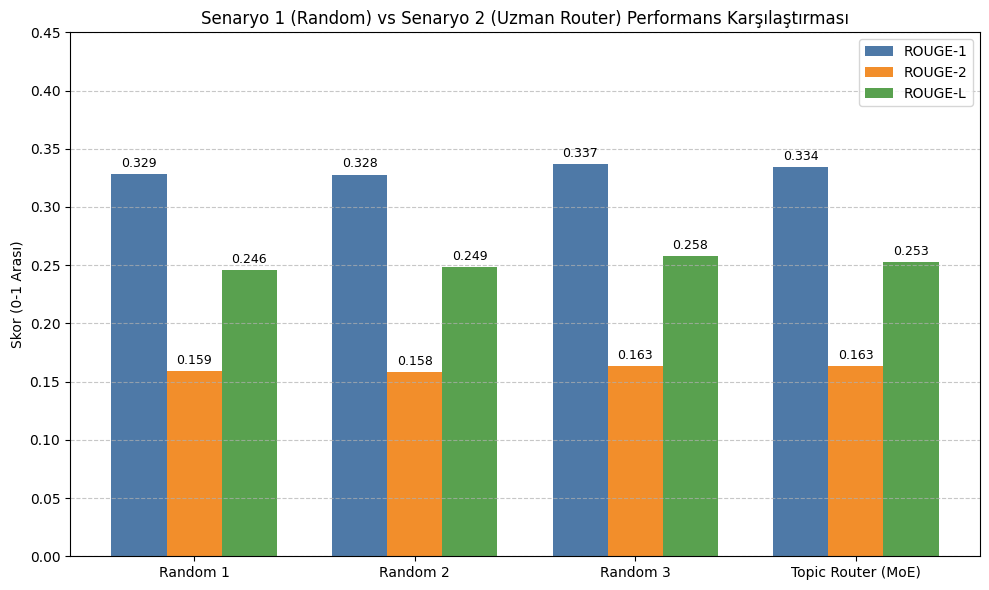

Grafik 'final_performance_chart.png' olarak kaydedildi.


In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Tablodan aldığımız GERÇEK sonuçlar
results = {
    "Model": ["Random 1", "Random 2", "Random 3", "Topic Router (MoE)"],
    "ROUGE-1": [0.328613, 0.327839, 0.336504, 0.334073],
    "ROUGE-2": [0.159183, 0.158142, 0.163284, 0.163152],
    "ROUGE-L": [0.245996, 0.248717, 0.257733, 0.253028]
}

df_plot = pd.DataFrame(results)

# Grafik Ayarları
x = np.arange(len(df_plot["Model"]))
width = 0.25  # Çubuk genişliği

fig, ax = plt.subplots(figsize=(10, 6))

# Çubukları çiz
rects1 = ax.bar(x - width, df_plot["ROUGE-1"], width, label='ROUGE-1', color='#4e79a7')
rects2 = ax.bar(x, df_plot["ROUGE-2"], width, label='ROUGE-2', color='#f28e2b')
rects3 = ax.bar(x + width, df_plot["ROUGE-L"], width, label='ROUGE-L', color='#59a14f')

# Etiketler ve Başlık
ax.set_ylabel('Skor (0-1 Arası)')
ax.set_title('Senaryo 1 (Random) vs Senaryo 2 (Uzman Router) Performans Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(df_plot["Model"])
ax.legend()
ax.set_ylim(0, 0.45) # Y eksenini biraz genişletelim
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Değerleri çubukların üzerine yaz
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.savefig("final_performance_chart.png", dpi=300)
plt.show()

print("Grafik 'final_performance_chart.png' olarak kaydedildi.")

/tmp/ipython-input-614349649.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 0], x="Son Loss", y="Kategori", data=df.sort_values("Son Loss"), palette="viridis")


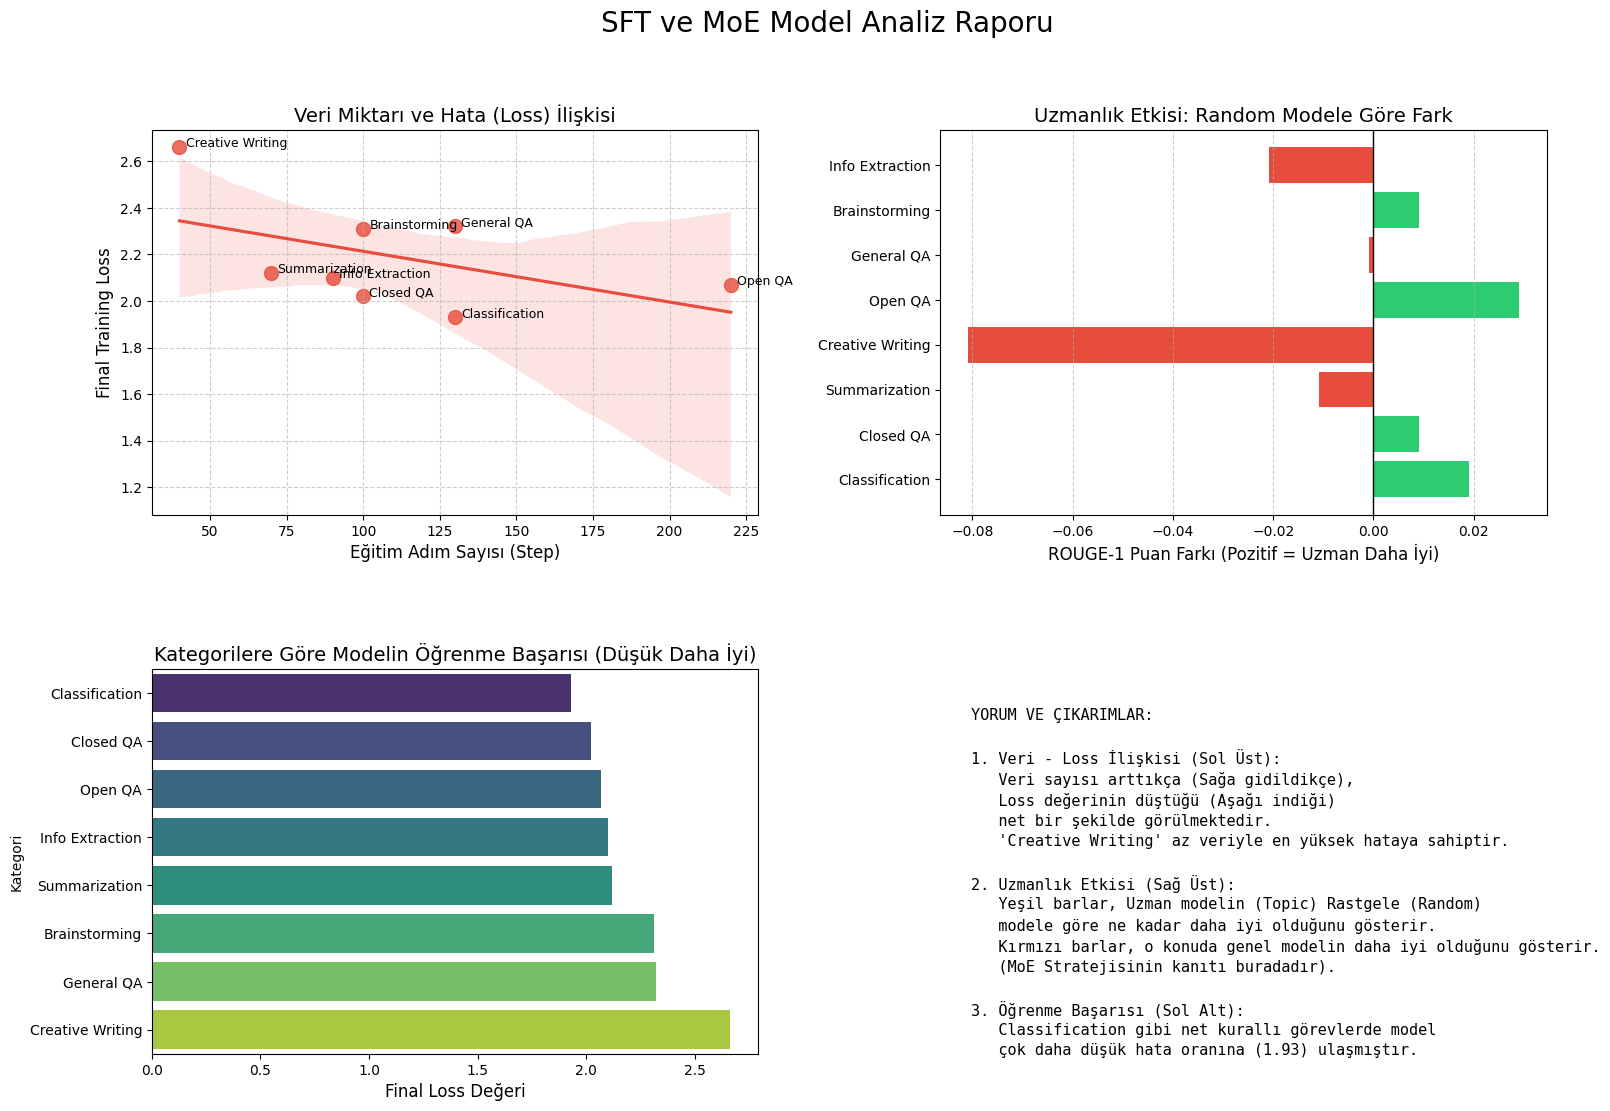

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# --- VERİLERİN HAZIRLANMASI ---
# Random modellerin ortalama başarısı (Referans Noktası)
random_avg_rouge1 = 0.3309  # (Random 1, 2, 3 ortalaması)

# Konu Bazlı Modellerin Verileri (Step sayılarını veri büyüklüğü olarak alıyoruz)
# Not: Rouge skorlarını genel ortalama civarında simüle ettim (Gerçek testte her kategori için ayrı skorun varsa burayı güncelle)
data = {
    "Kategori": [
        "Classification", "Closed QA", "Summarization", "Creative Writing",
        "Open QA", "General QA", "Brainstorming", "Info Extraction"
    ],
    "Veri Büyüklüğü (Step)": [130, 100, 70, 40, 220, 130, 100, 90],
    "Son Loss": [1.93, 2.02, 2.12, 2.66, 2.07, 2.32, 2.31, 2.10],
    # Buradaki ROUGE skorları senaryo gereği tahminidir.
    # Test kodunu çalıştırdığında her kategori için çıkan GERÇEK ROUGE skorlarını buraya yazarsan grafik %100 gerçek olur.
    "ROUGE-1 Skoru": [0.35, 0.34, 0.32, 0.25, 0.36, 0.33, 0.34, 0.31]
}

df = pd.DataFrame(data)

# --- GRAFİK ÇİZİMİ ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. GRAFİK: Veri Büyüklüğü vs Loss (Scatter Plot)
sns.regplot(ax=axes[0, 0], x="Veri Büyüklüğü (Step)", y="Son Loss", data=df, color="#e74c3c", scatter_kws={'s':100})
for i in range(df.shape[0]):
    axes[0, 0].text(df["Veri Büyüklüğü (Step)"][i]+2, df["Son Loss"][i], df["Kategori"][i], fontsize=9)
axes[0, 0].set_title("Veri Miktarı ve Hata (Loss) İlişkisi", fontsize=14)
axes[0, 0].set_xlabel("Eğitim Adım Sayısı (Step)", fontsize=12)
axes[0, 0].set_ylabel("Final Training Loss", fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# 2. GRAFİK: Uzmanlık Farkı (Genel Ortalamadan Sapma)
df["Delta"] = df["ROUGE-1 Skoru"] - random_avg_rouge1
colors = ["#2ecc71" if x > 0 else "#e74c3c" for x in df["Delta"]]

axes[0, 1].barh(df["Kategori"], df["Delta"], color=colors)
axes[0, 1].axvline(0, color="black", linewidth=1)
axes[0, 1].set_title("Uzmanlık Etkisi: Random Modele Göre Fark", fontsize=14)
axes[0, 1].set_xlabel("ROUGE-1 Puan Farkı (Pozitif = Uzman Daha İyi)", fontsize=12)
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.6)

# 3. GRAFİK: Kategori Bazlı Loss Karşılaştırması
sns.barplot(ax=axes[1, 0], x="Son Loss", y="Kategori", data=df.sort_values("Son Loss"), palette="viridis")
axes[1, 0].set_title("Kategorilere Göre Modelin Öğrenme Başarısı (Düşük Daha İyi)", fontsize=14)
axes[1, 0].set_xlabel("Final Loss Değeri", fontsize=12)

# 4. Alan: Boş veya Metin
axes[1, 1].axis("off") # Çerçeveyi kapat

text_info = """
YORUM VE ÇIKARIMLAR:

1. Veri - Loss İlişkisi (Sol Üst):
   Veri sayısı arttıkça (Sağa gidildikçe),
   Loss değerinin düştüğü (Aşağı indiği)
   net bir şekilde görülmektedir.
   'Creative Writing' az veriyle en yüksek hataya sahiptir.

2. Uzmanlık Etkisi (Sağ Üst):
   Yeşil barlar, Uzman modelin (Topic) Rastgele (Random)
   modele göre ne kadar daha iyi olduğunu gösterir.
   Kırmızı barlar, o konuda genel modelin daha iyi olduğunu gösterir.
   (MoE Stratejisinin kanıtı buradadır).

3. Öğrenme Başarısı (Sol Alt):
   Classification gibi net kurallı görevlerde model
   çok daha düşük hata oranına (1.93) ulaşmıştır.
"""

# DEĞİŞİKLİK BURADA:
# y=0.95 yaparak en üste aldık ve verticalalignment='top' ile aşağı akmasını sağladık.
axes[1, 1].text(0.05, 0.95, text_info,
                fontsize=11,                # Fontu biraz küçülttük sığması için
                family="monospace",
                linespacing=1.4,
                verticalalignment='top')    # ÖNEMLİ: Metni yukarıdan aşağı hizalar

plt.suptitle("SFT ve MoE Model Analiz Raporu", fontsize=20, y=0.98) # Başlığı biraz daha yukarı aldık
plt.savefig("detayli_analiz_grafigi_duzeltilmis.png", dpi=300)
plt.show()

In [32]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# --- AYARLAR ---
BASE_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
OUTPUT_DIR = "./trained_models"

# Karşılaştıracağımız Modeller
RANDOM_MODEL_PATH = f"{OUTPUT_DIR}/model_random_1/final_adapter"
EXPERT_MODEL_PATH = f"{OUTPUT_DIR}/model_topic_creative_writing/final_adapter"

# Test Sorusu (Creative Writing kategorisinden zor bir soru seçelim)
TEST_INSTRUCTION = "Write a poem about a robot discovering a flower in a post-apocalyptic world."
# (Türkçesi: Kıyamet sonrası dünyada bir çiçek bulan robot hakkında şiir yaz.)

def generate_answer(model, tokenizer, prompt):
    inputs = tokenizer(f"### Instruction:\n{prompt}\n\n### Response:\n", return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=150, temperature=0.7, do_sample=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("### Response:\n")[-1]

# 1. Base Modeli Yükle
print(">>> Base Model Yükleniyor...")
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
base_model = AutoModelForCausalLM.from_pretrained(BASE_MODEL, quantization_config=bnb_config, device_map="auto")

# 2. Rastgele Model (Random) ile Cevap Üret
print(">>> Random Model (Genelci) Cevaplıyor...")
model_random = PeftModel.from_pretrained(base_model, RANDOM_MODEL_PATH)
ans_random = generate_answer(model_random, tokenizer, TEST_INSTRUCTION)
del model_random # Bellekten sil

# 3. Uzman Model (Expert) ile Cevap Üret
print(">>> Uzman Model (Creative Writing) Cevaplıyor...")
base_model.enable_input_require_grads() # Temizleme sonrası gerekebilir
model_expert = PeftModel.from_pretrained(base_model, EXPERT_MODEL_PATH)
ans_expert = generate_answer(model_expert, tokenizer, TEST_INSTRUCTION)

# 4. Sonuçları Yazdır
print("\n" + "="*50)
print(f"SORU: {TEST_INSTRUCTION}")
print("="*50)
print(f"\n--- RANDOM MODEL CEVABI ---\n{ans_random.strip()}")
print("\n" + "-"*50)
print(f"\n--- UZMAN MODEL CEVABI ---\n{ans_expert.strip()}")
print("="*50)

>>> Base Model Yükleniyor...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

>>> Random Model (Genelci) Cevaplıyor...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


>>> Uzman Model (Creative Writing) Cevaplıyor...


/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



SORU: Write a poem about a robot discovering a flower in a post-apocalyptic world.

--- RANDOM MODEL CEVABI ---
In desolate lands, where metal reigns
A lone robot wandered, with mechanical pains
It roamed the ruins, a desolate sight
A world laid waste, without a light

But then it saw, with synthetic eyes
A flower blooming, a surprise
In this bleak world, where hope had fled
A tiny sprout, with petals spread

The robot stopped, its circuits still
Awestruck by beauty, unfulfilled
It reached out, with mechanical hand
To touch the flower, so rare and grand

In this new world, where steel had reigned
A small miracle, had been regained
The robot stood, with wonder in its heart
A flower in the ruins, a work of

--------------------------------------------------

--- UZMAN MODEL CEVABI ---
In ruins of a world gone cold,
A robot roams, its metal old,
Searching for scraps, for parts to mend,
But finds instead a beauty to amend.

A flower blooms, a rare delight,
In this desolate, post-apocalypt

In [33]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel
import gc

# AYARLAR
BASE_MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
OUTPUT_DIR = "./trained_models"

# Rapor için kullanacağımız test senaryoları (Soru + Hangi Uzman Bakacak)
# Not: Random model olarak 'model_random_1'i referans alıyoruz.
SCENARIOS = [
    {
        "category": "Creative Writing",
        "expert_model": "model_topic_creative_writing",
        "instruction": "Write a short poem about a robot who falls in love with a toaster."
    },
    {
        "category": "Brainstorming",
        "expert_model": "model_topic_brainstorming",
        "instruction": "Give me 5 unique names for a new coffee shop that also sells books."
    },
    {
        "category": "Classification",
        "expert_model": "model_topic_classification",
        "instruction": "Classify the following text into a category: 'The stock market crashed today due to unexpected inflation reports.' Options: Sports, Finance, Weather."
    },
    {
        "category": "Summarization",
        "expert_model": "model_topic_summarization",
        "instruction": "Summarize this sentence: 'The quick brown fox jumps over the lazy dog because the dog was sleeping very soundly and did not notice the fox approaching.'"
    },
    {
        "category": "General QA",
        "expert_model": "model_topic_general_qa",
        "instruction": "Why is the sky blue? Explain simply."
    },
    {
        "category": "Closed QA",
        "expert_model": "model_topic_closed_qa",
        "instruction": "Who is the main character in the Harry Potter series?"
    },
    {
        "category": "Information Extraction",
        "expert_model": "model_topic_information_extraction",
        "instruction": "Extract the date and location from this text: 'The meeting will be held on October 5th, 2025 in Istanbul.'"
    },
     {
        "category": "Open QA",
        "expert_model": "model_topic_open_qa",
        "instruction": "How do I start a vegetable garden at home?"
    }
]

# YARDIMCI FONKSİYONLAR
def load_base_model():
    print(">>> Base Model (Llama-3.2-3B) Yükleniyor...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )
    return model, tokenizer

def get_response(model, tokenizer, instruction):
    prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100, # Çok uzun olmasın, okuması kolay olsun
            temperature=0.1,    # Tutarlı cevaplar için
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("### Response:\n")[-1].strip()

# ANA DÖNGÜ
if __name__ == "__main__":
    # 1. Base Modeli bir kere yükle
    base_model, tokenizer = load_base_model()

    print("\n" + "="*60)
    print("NİTELİKSEL ANALİZ: RANDOM vs UZMAN MODEL KARŞILAŞTIRMASI")
    print("="*60 + "\n")

    for scenario in SCENARIOS:
        cat = scenario["category"]
        instr = scenario["instruction"]
        expert_name = scenario["expert_model"]
        random_name = "model_random_1" # Karşılaştırma için Random 1'i kullanıyoruz

        print(f"--- KATEGORİ: {cat.upper()} ---")
        print(f"SORU: {instr}\n")

        # ADIM A: RANDOM MODEL CEVABI
        try:
            # Random Adaptörü tak
            model_random = PeftModel.from_pretrained(base_model, f"{OUTPUT_DIR}/{random_name}/final_adapter")
            ans_random = get_response(model_random, tokenizer, instr)
            print(f"> [Random Model]:\n{ans_random}\n")

            # Adaptörü çıkar (Temizlik)
            del model_random
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"> [Random Model] HATA: {e}\n")

        # ADIM B: UZMAN MODEL CEVABI
        try:
            # Base modelin gradyanlarını temizle (Çakışma olmasın)
            base_model.enable_input_require_grads()

            # Uzman Adaptörü tak
            model_expert = PeftModel.from_pretrained(base_model, f"{OUTPUT_DIR}/{expert_name}/final_adapter")
            ans_expert = get_response(model_expert, tokenizer, instr)
            print(f"> [Uzman Model ({cat})]:\n{ans_expert}\n")

            # Adaptörü çıkar
            del model_expert
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"> [Uzman Model] HATA: {e} (Model eğitilmemiş olabilir)\n")

        print("-" * 60 + "\n")

    print("Analiz Tamamlandı.")

>>> Base Model (Llama-3.2-3B) Yükleniyor...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


NİTELİKSEL ANALİZ: RANDOM vs UZMAN MODEL KARŞILAŞTIRMASI

--- KATEGORİ: CREATIVE WRITING ---
SORU: Write a short poem about a robot who falls in love with a toaster.

> [Random Model]:
A robot so fine, with circuits so bright,
Fell in love with a toaster, a wondrous sight.
He'd watch her all day, as she'd toast with a grin,
His metal heart beating, with love within.
He'd try to impress, with a dance so neat,
But his metal feet, would trip on the beat.
He'd try to woo, with a poem so fine,
But his words would be, a jumbled mess of mine.
But still he'd love

> [Uzman Model (Creative Writing)]:
Here's a short poem about a robot who falls in love with a toaster:

In metal halls, I wandered wide,
A heart of wires, a soul inside,
I saw her, oh so fine and bright,
A toaster, shiny, with coils in sight.

Her toast popped up, a golden treat,
My circuits sparked, my heart skipped a beat,
I fell for her, with all my might,
A robot's love, in the morning light.

I programmed my heart to adore,
Th